In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, losses

print(tf.__version__)

2.0.0


In [3]:
# 在线下载汽车效能数据集
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [4]:
# 效能（公里数每加仑），气缸数，排量，马力，重量
# 加速度，型号年份，产地
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

In [5]:
dataset = raw_dataset.copy()

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

In [10]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [11]:
# 处理类别型数据，其中origin列代表了类别1,2,3,分布代表产地：美国、欧洲、日本
# 其弹出这一列
origin = dataset.pop('Origin')
# 根据origin列来写入新列
dataset['USA'] = (origin == 1)* 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

In [12]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)  # 先取出训练数据
test_dataset = dataset.drop(train_dataset.index)  # 再按照训练数据的索引在元数据上删除，获得剩余测试数据

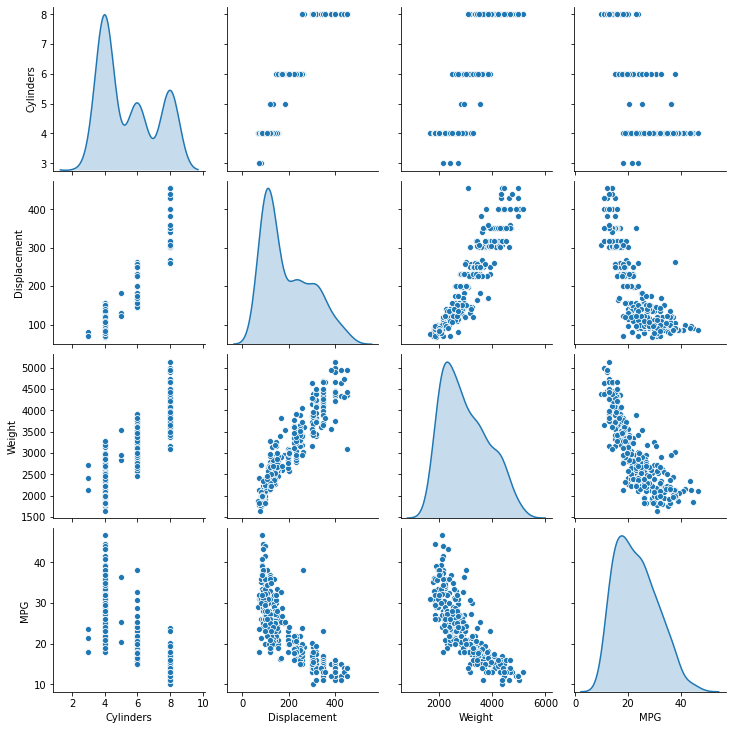

In [16]:
sns.pairplot(train_dataset[["Cylinders", "Displacement", "Weight", "MPG"]], 
diag_kind="kde")

In [15]:
# 查看训练集的输入X的统计数据
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [17]:
# 移动MPG油耗效能这一列为真实标签Y
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [18]:
# 标准化数据
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [19]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [20]:
print(normed_train_data.shape,train_labels.shape)
print(normed_test_data.shape, test_labels.shape)

(314, 9) (314,)
(78, 9) (78,)


In [21]:
class Network(keras.Model):
    # 回归网络
    def __init__(self):
        super(Network, self).__init__()
        # 创建3个全连接层
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(1)
    
    def call(self, inputs, training=None, mask=None):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

In [22]:
model = Network()
# 通过 build 函数完成内部张量的创建，其中 4 为任意设置的 batch 数量，9 为输入特征长度
model.build(input_shape=(None, 9))
model.summary() # 打印网络信息
optimizer = tf.keras.optimizers.RMSprop(0.001)  # 创建优化器，指定学习率
train_db = tf.data.Dataset.from_tensor_slices((normed_train_data.values, train_labels.values))
train_db = train_db.shuffle(100).batch(32)  # 随机打散批量化

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  640       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [23]:
train_mae_losses = []
test_mae_losses = []
for epoch in range(200):  # 200个epoch
    for step, (x, y) in enumerate(train_db):  # 遍历一次训练集
        # 梯度记录器，训练时使用它
        with tf.GradientTape() as tape:
            out = model(x)  # 通过网络输出
            loss = tf.reduce_mean(losses.MSE(y, out))  # 计算MSE
            mae_loss = tf.reduce_mean(losses.MAE(y, out))  # 计算MAE
        
        if step % 10 == 0:  # 间隔性打印训练误差
            print(epoch, step, float(loss))
        
        # 计算梯度并更新
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
    train_mae_losses.append(float(mae_loss))  # 训练误差是收集
    out = model(tf.constant(normed_test_data.values))  # 每次循环后，测试集的检测
    test_mae_losses.append(tf.reduce_mean(losses.MAE(test_labels, out)))  # 误差收集


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0 0 535.2652587890625
1 0 513.7008056640625
2 0 386.0516052246094
3 0 306.1305236816406
4 0 240.26963806152344
5 0 233.33901977539062
6 0 140.8110809326172
7 0 139.71554565429688
8 0 128.04873657226562
9 0 81.24137878417969
10 0 94.50222778320312
11 0 70.87873840332031
12 0 69.44293212890625
13 0 84.56625366210938
14 0 66.27291870117188
15 0 69.09393310546875
16 0 95.72203063964844
17 0 84.89181518554688
18 0 61.80917739868164
19 0 63.52794647216797
20 0 59.36132049560547
21 0 47.9665412902832
22 0 73.4

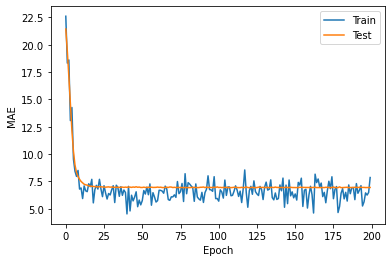

In [24]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(train_mae_losses, label='Train')
plt.plot(test_mae_losses, label='Test')
plt.legend()
plt.show()